## Project Name: Data Driven property in Spain

#### Author: MCKitchen (mckeuken@gmail.com)

    Goal of the project: one of the ideas that I have is to buy a property in Spain. Why? I feel that the 
    weather is nicer. But is that actually the case and what are the differences throughout the country?
    
    To answer these questions I basically downloaded all the weather data that I could find from the NOAA
    website (other countries might be fun for a different project) and started plotting the data of spain.

In [1]:
# Importing the differen modules:
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.preprocessing import scale

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# have fun installing it.. https://matplotlib.org/basemap/users/installing.html

# Image parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]
sns.set_style("darkgrid")

# Directory info
# First setting the path where the NOAA data is stored:
dataDir = "/Users/mckitchen/Documents/Funprojects.nosynch/WeatherPlotting/gsom-latest/"


In [ ]:
# So... there are a lot of files and folders... Lets first clean this up by selecting the csv files 
# based on their content. I.e. we only want to play with temp and prcp as these are the most important ones
# for me. So check the csv header and see whether the file contains any column that matches my data selection.
# if not, move the csv to a different folder as it might be usefull in the future. 
# Lets get going:

# Then for all the different folders 
for dirs in os.listdir(dataDir):
    # while making sure that we exclude all hidden folders:
    if not dirs.startswith('.'):
        path = os.path.join(dataDir + dirs)
        # For all the different files in those folders
        for file in os.listdir(path):
            # Only open the csv files:
            fileExtension = file.split(".")[-1]
            if fileExtension == "csv":
                filepath = os.path.join(path+'/'+file)
                #print(filepath)
                # Read the first line of those files
                data = pd.read_csv(filepath,nrows=1)
                # We only want to have the data from stations that have TAVG and PRCP data
                if 'TAVG' in data.columns:
                    if 'PRCP' in data.columns:
                        print('Both TAVG and PRCP')
                    else:
                        if not os.path.exists(path+"/noPRCP"):
                            os.makedirs(path+"/noPRCP")  
                        shutil.move(filepath, os.path.join(path+"/noPRCP"))
                else:
                    if not os.path.exists(path+"/noTAVG"):
                        os.makedirs(path+"/noTAVG") 
                    shutil.move(filepath, os.path.join(path+"/noTAVG"))
    
# After these loops we moved the datafiles of the different weather stations that do not contain 
# any information about the average temperature or average percepitation.
      

In [ ]:
# We now want to read all the data of all these stations into a data frame where we only select a 
# number of columns: STATION, DATE, LATITUDE, LONGITUDE, ELEVATION, NAME, PRCP and TAVG:

# Empty dataframe which we will concat all the seperate aggregated data intoL:
dfTotal = pd.DataFrame(columns=['Name','Station','Latitude', 'Longitude', 'Elevation', 'Month','TempAvg', 'PrcpAvg','TempStd', 'PrcpStd'])

# Start the for loop:
for dirs in os.listdir(dataDir):
    if not dirs.startswith('.'):
        path = os.path.join(dataDir + dirs)
        print(path)
        # For all the different files in those folders
        for file in os.listdir(path):
            print(file)
            # Only open the csv files:
            fileExtension = file.split(".")[-1]
            if fileExtension == "csv":
                filepath = os.path.join(path+'/'+file)
                # Read the csv files into a dataframe:
                df = pd.read_csv(filepath)
                df = df[['STATION','DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'PRCP', 'TAVG']]
                
                # One of the downsides of having a selection filter is that you lose data but due to the downside of
                # human-induced global warming is that weather data from the 1900 is really not that informative for 
                # the weather in 2019... For instance based on the global temperature anomalies data, from 1980
                # onwards the temperature has been structurally been above normal. Therefore we are only going to take 
                # data from 1980 and onwards.  
                # I'm going to build a date selection filter based on the colum 'date' by pulling the string apart 
                # in year and month:
                df['YEAR'] = df.DATE.str[:4].astype(int)
                df['MONTH'] = df.DATE.str[5:7].astype(int)
                # And then only use the data for which the year is equal or larger than 1980:
                df = df[df.YEAR >= 1980]
                # It is possible that that due to the date filter we end up with no data from a given weather station.
                # So I'll first check if the df is empty, if so, we can just continue with the next dataset:
                if df.empty:
                    continue
                    
                # So it might happen that we are missing a month and this can be fully random. What this means is that
                # we need to create an empty row for that month but WITH all the other information:
                dfEmpty = pd.DataFrame({'MonthNR': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'MonthName':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']})
                dfMerged = pd.merge(dfEmpty, df, how='outer', left_on='MonthNR', right_on='MONTH' )
                
                # Aggregate per month:
                dfAvg = dfMerged.groupby('MonthNR', group_keys = True).mean()[['TAVG','PRCP']]
                dfStd = dfMerged.groupby('MonthNR', group_keys = True).std()[['TAVG','PRCP']]
                
                # Add all the colums to the aggregated dataframe:
                dfAvg['STATION'] = dfMerged['STATION'].iloc[:12].values
                dfAvg['NAME'] = dfMerged['NAME'].iloc[:12].values
                dfAvg['LATITUDE'] = dfMerged['LATITUDE'].iloc[:12].values
                dfAvg['LONGITUDE'] = dfMerged['LONGITUDE'].iloc[:12].values
                dfAvg['ELEVATION'] = dfMerged['ELEVATION'].iloc[:12].values
                dfAvg['MONTH'] = dfEmpty['MonthName'].iloc[:12].values
                dfAvg['TSTD'] = dfStd['TAVG']
                dfAvg['PRCPSTD'] = dfStd['PRCP']
                # Reorder for readability:
                dfAvg = dfAvg[['NAME', 'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION','MONTH', 'TAVG', 'PRCP', 'TSTD', 'PRCPSTD']]
                dfAvg.columns= ['Name','Station','Latitude', 'Longitude', 'Elevation', 'Month','TempAvg', 'PrcpAvg','TempStd', 'PrcpStd']
                # Combine the aggregated data into a single dataframe:
                dfTotal = pd.concat([dfTotal, dfAvg])
# Since there are a LOT of files to read this takes a while and we don't want to do this everytime we start
# the notebook. So I'll write the combined aggregated data into a csv file:
dfTotal.to_csv('data.csv')                
# finally we want to print the shape:
print(dfTotal.shape)

In [3]:
# How many weatherstations did we include?
dfTotal = pd.read_csv('data.csv')
print(dfTotal.shape[0]/12)
# And how does the data look like?
dfTotal.head()

23221.0


,Unnamed: 0,Name,Station,Latitude,Longitude,Elevation,Month,TempAvg,PrcpAvg,TempStd,PrcpStd
0,1,"AUE, GM",GME00123838,50.5917,12.7156,387.0,Jan,0.014211,56.789474,2.881941,28.501198
1,2,"AUE, GM",GME00123838,50.5917,12.7156,387.0,Feb,0.615526,47.952632,3.183416,24.874058
2,3,"AUE, GM",GME00123838,50.5917,12.7156,387.0,Mar,3.971579,56.776316,2.100281,29.117028
3,4,"AUE, GM",GME00123838,50.5917,12.7156,387.0,Apr,8.020263,58.007895,1.762835,35.441077
4,5,"AUE, GM",GME00123838,50.5917,12.7156,387.0,May,12.693947,73.981579,1.402431,38.165825


In [4]:
# Data cleanup
# If all station information is missing then we are not interested in the data anyways. So I'm going to remove 
# it here:
dfTotal = dfTotal.dropna(subset=['Name', 'Station', 'Latitude', 'Longitude', 'Elevation'], how='all')
# We also have a few stations that do have a name but no further information can be found via google.
# Therefore I'm going to drop those cases here as well:
dfTotal= dfTotal[dfTotal.Station != 'USC00412090']
dfTotal= dfTotal[dfTotal.Station != 'USC00058904']
dfTotal= dfTotal[dfTotal.Station != 'USC00364545']

In [5]:
# Are there weather stations that have some but not all information?
# It seems that 'Elevation' seems to be missing most of the time so lets use that variable to check if there are any indexes where 
# elevation is a nan?
print(np.where(np.isnan(dfTotal['Elevation'])))

(array([   168,    169,    170,    171,    172,    173,    174,    175,
          176,    177,    178,    179,  10618,  10619,  10620,  10621,
        10622,  10623,  10624,  10625,  10626,  10627,  10628,  10629,
        10954,  10955,  10956,  10957,  10958,  10959,  10960,  10961,
        10962,  10963,  10964,  10965,  11350,  11351,  11352,  11353,
        11354,  11355,  11356,  11357,  11358,  11359,  11360,  11361,
        11446,  11447,  11448,  11449,  11450,  11451,  11452,  11453,
        11454,  11455,  11456,  11457,  14389,  14390,  14391,  14392,
        14393,  14394,  14395,  14396,  14397,  14398,  14399,  14400,
        42430,  42431,  42432,  42433,  42434,  42435,  42436,  42437,
        42438,  42439,  42440,  42441,  42454,  42455,  42456,  42457,
        42458,  42459,  42460,  42461,  42462,  42463,  42464,  42465,
        42466,  42467,  42468,  42469,  42470,  42471,  42472,  42473,
        42474,  42475,  42476,  42477,  42478,  42479,  42480,  42481,
     

In [6]:
# Clean up the data based on the stationname and information found on http://berkeleyearth.org/
# There are a number of weather stations that miss quite alot of information:
dfTotal.loc[dfTotal.Station == 'GME00111524', 'Name'] = 'MUNICH/RIEM, GM'
dfTotal.loc[dfTotal.Station == 'GME00111524', 'Latitude'] = 48.3643
dfTotal.loc[dfTotal.Station == 'GME00111524', 'Longitude'] = 11.7974 
dfTotal.loc[dfTotal.Station == 'GME00111524', 'Elevation'] = 448.28

dfTotal.loc[dfTotal.Station == 'SPE00120098', 'Name'] = 'ARMILLA, SP'
dfTotal.loc[dfTotal.Station == 'SPE00120098', 'Latitude'] = 37.1367
dfTotal.loc[dfTotal.Station == 'SPE00120098', 'Longitude'] = 3.6314 
dfTotal.loc[dfTotal.Station == 'SPE00120098', 'Elevation'] = 686.50

dfTotal.loc[dfTotal.Station == 'SPE00119873', 'Name'] = 'PALMA DE MALLORCA, SP'
dfTotal.loc[dfTotal.Station == 'SPE00119873', 'Latitude'] = 39.5778
dfTotal.loc[dfTotal.Station == 'SPE00119873', 'Longitude'] = 2.6500 
dfTotal.loc[dfTotal.Station == 'SPE00119873', 'Elevation'] = 10.00

dfTotal.loc[dfTotal.Station == 'SPE00119927', 'Name'] = 'CACERES CIUDAD, SP'
dfTotal.loc[dfTotal.Station == 'SPE00119927', 'Latitude'] = 39.4831
dfTotal.loc[dfTotal.Station == 'SPE00119927', 'Longitude'] = 6.3667
dfTotal.loc[dfTotal.Station == 'SPE00119927', 'Elevation'] = 459.00 

dfTotal.loc[dfTotal.Station == 'SPE00119891', 'Name'] = 'BARCELONA, SP'
dfTotal.loc[dfTotal.Station == 'SPE00119891', 'Latitude'] = 41.4192
dfTotal.loc[dfTotal.Station == 'SPE00119891', 'Longitude'] = 2.1253
dfTotal.loc[dfTotal.Station == 'SPE00119891', 'Elevation'] = 412.00

dfTotal.loc[dfTotal.Station == 'JN000099950', 'Name'] = 'JAN-MAYEN, NW'
dfTotal.loc[dfTotal.Station == 'JN000099950', 'Latitude'] = 70.9300
dfTotal.loc[dfTotal.Station == 'JN000099950', 'Longitude'] = 7.3300 
dfTotal.loc[dfTotal.Station == 'JN000099950', 'Elevation'] = 10.00

dfTotal.loc[dfTotal.Station == 'SWE00138826', 'Name'] = 'JAN-MAYEN, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00138826', 'Latitude'] = 59.2600 
dfTotal.loc[dfTotal.Station == 'SWE00138826', 'Longitude'] = 15.2250
dfTotal.loc[dfTotal.Station == 'SWE00138826', 'Elevation'] = 29.00

dfTotal.loc[dfTotal.Station == 'SWE00138748', 'Name'] = 'VINGAKER, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00138748', 'Latitude'] = 59.0800 
dfTotal.loc[dfTotal.Station == 'SWE00138748', 'Longitude'] = 15.8200
dfTotal.loc[dfTotal.Station == 'SWE00138748', 'Elevation'] = 60.00

dfTotal.loc[dfTotal.Station == 'SWE00101863', 'Name'] = 'GOTEBORG, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00101863', 'Latitude'] = 57.7158 
dfTotal.loc[dfTotal.Station == 'SWE00101863', 'Longitude'] = 11.9942
dfTotal.loc[dfTotal.Station == 'SWE00101863', 'Elevation'] = 5.00

dfTotal.loc[dfTotal.Station == 'SWE00137838', 'Name'] = 'Halmstad, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00137838', 'Latitude'] = 56.6750
dfTotal.loc[dfTotal.Station == 'SWE00137838', 'Longitude'] = 12.9200
dfTotal.loc[dfTotal.Station == 'SWE00137838', 'Elevation'] = 43.78

dfTotal.loc[dfTotal.Station == 'SWE00138730', 'Name'] = 'VINGAKER, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00138730', 'Latitude'] = 59.6700 
dfTotal.loc[dfTotal.Station == 'SWE00138730', 'Longitude'] = 15.9600
dfTotal.loc[dfTotal.Station == 'SWE00138730', 'Elevation'] = 67

dfTotal.loc[dfTotal.Station == 'SWE00137798', 'Name'] = 'KNARED, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00137798', 'Latitude'] = 56.5200 
dfTotal.loc[dfTotal.Station == 'SWE00137798', 'Longitude'] = 13.3400
dfTotal.loc[dfTotal.Station == 'SWE00137798', 'Elevation'] = 35

dfTotal.loc[dfTotal.Station == 'SWE00139588', 'Name'] = 'SODERHAMN, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00139588', 'Latitude'] = 61.2700 
dfTotal.loc[dfTotal.Station == 'SWE00139588', 'Longitude'] = 17.1000
dfTotal.loc[dfTotal.Station == 'SWE00139588', 'Elevation'] = 10

dfTotal.loc[dfTotal.Station == 'SWE00139934', 'Name'] = 'BISPGARDEN, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00139934', 'Latitude'] = 63.0400
dfTotal.loc[dfTotal.Station == 'SWE00139934', 'Longitude'] = 16.5450
dfTotal.loc[dfTotal.Station == 'SWE00139934', 'Elevation'] = 170

dfTotal.loc[dfTotal.Station == 'SWE00140016', 'Name'] = 'STORLIEN-VISJOVALEN, SWE'
dfTotal.loc[dfTotal.Station == 'SWE00140016', 'Latitude'] = 63.3028
dfTotal.loc[dfTotal.Station == 'SWE00140016', 'Longitude'] = 12.1253
dfTotal.loc[dfTotal.Station == 'SWE00140016', 'Elevation'] = 642

dfTotal.loc[dfTotal.Station == 'FRE00104910', 'Name'] = 'NIMES, FRE'
dfTotal.loc[dfTotal.Station == 'FRE00104910', 'Latitude'] = 43.8581
dfTotal.loc[dfTotal.Station == 'FRE00104910', 'Longitude'] = 4.4067 
dfTotal.loc[dfTotal.Station == 'FRE00104910', 'Elevation'] = 59.00 

dfTotal.loc[dfTotal.Station == 'FRE00104951', 'Name'] = 'BEAUVAIS-TILLE, FRE'
dfTotal.loc[dfTotal.Station == 'FRE00104951', 'Latitude'] = 49.4467 
dfTotal.loc[dfTotal.Station == 'FRE00104951', 'Longitude'] = 2.1281 
dfTotal.loc[dfTotal.Station == 'FRE00104951', 'Elevation'] = 89.00 

dfTotal.loc[dfTotal.Station == 'FRE00104921', 'Name'] = 'SETE, FRE'
dfTotal.loc[dfTotal.Station == 'FRE00104921', 'Latitude'] = 43.3981
dfTotal.loc[dfTotal.Station == 'FRE00104921', 'Longitude'] = 3.6917 
dfTotal.loc[dfTotal.Station == 'FRE00104921', 'Elevation'] = 80.00 

dfTotal.loc[dfTotal.Station == 'NTM00078866', 'Name'] = 'Philipsburg, NTM'
dfTotal.loc[dfTotal.Station == 'NTM00078866', 'Latitude'] = 18.0410
dfTotal.loc[dfTotal.Station == 'NTM00078866', 'Longitude'] = -63.1090 
dfTotal.loc[dfTotal.Station == 'NTM00078866', 'Elevation'] = 4

dfTotal.loc[dfTotal.Station == 'NTM00078988', 'Name'] = 'Hato, NTM'
dfTotal.loc[dfTotal.Station == 'NTM00078988', 'Latitude'] = 12.1890
dfTotal.loc[dfTotal.Station == 'NTM00078988', 'Longitude'] = -68.9600
dfTotal.loc[dfTotal.Station == 'NTM00078988', 'Elevation'] = 8.8

dfTotal.loc[dfTotal.Station == 'NOE00105477', 'Name'] = 'JAN MAYEN, NOE'
dfTotal.loc[dfTotal.Station == 'NOE00105477', 'Latitude'] = 70.9241 
dfTotal.loc[dfTotal.Station == 'NOE00105477', 'Longitude'] = 8.6875
dfTotal.loc[dfTotal.Station == 'NOE00105477', 'Elevation'] = 9.43

# There are a number of weather stations that only miss the elevation information:
dfTotal.loc[dfTotal.Station == 'IDM00097182', 'Elevation'] = 70
dfTotal.loc[dfTotal.Station == 'BL000085041', 'Elevation'] = 253.50 
dfTotal.loc[dfTotal.Station == 'BL000085230', 'Elevation'] = 4056.73
dfTotal.loc[dfTotal.Station == 'BL000085230', 'Elevation'] = 4056.73
dfTotal.loc[dfTotal.Station == 'BL000085223', 'Elevation'] = 2559.23
dfTotal.loc[dfTotal.Station == 'BL000085141', 'Elevation'] = 201.78
dfTotal.loc[dfTotal.Station == 'BL000085365', 'Elevation'] = 645.00
dfTotal.loc[dfTotal.Station == 'AYM00089514', 'Elevation'] = 130
dfTotal.loc[dfTotal.Station == 'AYW00090001', 'Elevation'] = 2826.50
dfTotal.loc[dfTotal.Station == 'UPM00033958', 'Elevation'] = 784.71 
dfTotal.loc[dfTotal.Station == 'UPM00033515', 'Elevation'] = 888
dfTotal.loc[dfTotal.Station == 'USC00169610', 'Elevation'] = 43
dfTotal.loc[dfTotal.Station == 'ASN00086384', 'Elevation'] = 114.40 

# Did we get them all?
print(np.where(np.isnan(dfTotal['Elevation'])))

(array([], dtype=int64),)


In [7]:
# Do we have plausible values?
print(dfTotal.describe())
# Um Latitude en Longitude sure but Elevation max 13109 meters?
# Given that mount everest is 8848 meters this seems somewhat unlikely
np.where(dfTotal['Elevation']>= 8850)
# This apperently is the weather station 'USW00023170' aka Hanksville UT US, which according to 
# Wikipedia is located at 1309meters and not 13109.4... so this seems to be a typo which we are going to
# fix here:
dfTotal.loc[dfTotal.Station == 'USW00023170', 'Elevation'] = 1309.4

          Unnamed: 0       Latitude      Longitude      Elevation  \
count  274592.000000  274592.000000  274592.000000  274592.000000   
mean        6.506661      37.561956     -49.333606     517.104790   
std         3.448690      22.487858      82.492984     657.930686   
min         1.000000     -90.000000    -179.366900    -350.000000   
25%         4.000000      35.083000    -106.883000      82.300000   
50%         7.000000      42.517500     -84.353330     260.000000   
75%        10.000000      49.216700       9.835800     663.000000   
max        12.000000      82.516700     179.320000   13109.400000   

             TempAvg        PrcpAvg        TempStd        PrcpStd  
count  251099.000000  270016.000000  239648.000000  260871.000000  
mean       10.210894      69.811098       1.740058      40.092836  
std        11.194608      59.195590       0.916246      31.669486  
min       -60.025333       0.000000       0.000000       0.000000  
25%         2.612071      30.320517   

In [8]:
# Saving the cleanup data
dfTotal.to_csv('dataCleanedUp.csv') 

In [2]:
dfTotal = pd.read_csv('dataCleanedUp.csv')

Matplotlib is building the font cache using fc-list. This may take a moment.


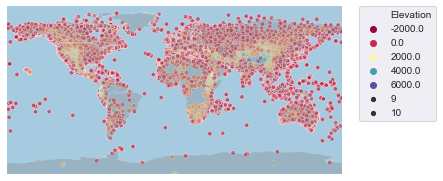

In [3]:
# where are the stations located?
# Let start with a worldmap for the background:
m=Basemap(llcrnrlon=-180, llcrnrlat=-90, urcrnrlon=180, urcrnrlat=90)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# On top of that worldmap we now want to plot all the weather stations:
sns.scatterplot(x=dfTotal['Longitude'], 
                y=dfTotal['Latitude'], 
                hue=dfTotal['Elevation'], 
                alpha=0.1, 
                size=10,
                palette='Spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# So we are not going to be able to say a lot about the Amazone, sahara, central africa and south/west china.
# The elevation column for color does not seem to be scaled very nice.

In [6]:
# Rescale the data 
dfTotal['ElevationScale'] = scale( dfTotal['Elevation'], axis=0, with_mean=True, with_std=True, copy=True )
nullIndexTemp = dfTotal['TempAvg'].isnull()
nullIndexPercp = dfTotal['PrcpAvg'].isnull()
dfTotal['TempAvgScale'] = dfTotal['TempAvg']
dfTotal['PrcpAvgScale'] = dfTotal['PrcpAvg']
dfTotal.loc[~nullIndexTemp, ['TempAvgScale']]= scale( dfTotal.loc[~nullIndexTemp, ['TempAvg']], axis=0, with_mean=True, with_std=True, copy=True )
dfTotal.loc[~nullIndexPercp, ['PrcpAvgScale']]= scale( dfTotal.loc[~nullIndexPercp, ['PrcpAvg']], axis=0, with_mean=True, with_std=True, copy=True )


/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


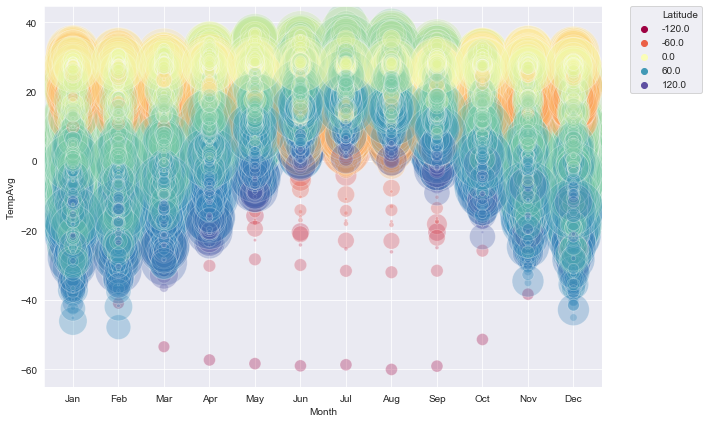

In [11]:
# Lets start to plot the temperature over time and lets take latitute in to account:
sns.scatterplot(x=dfTotal['Month'], 
                y=dfTotal['TempAvg'], 
                hue=dfTotal['Latitude'], 
                s=dfTotal['Elevation'], 
                alpha=0.3, 
                palette='Spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# hehe oke, pretty but useless

/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


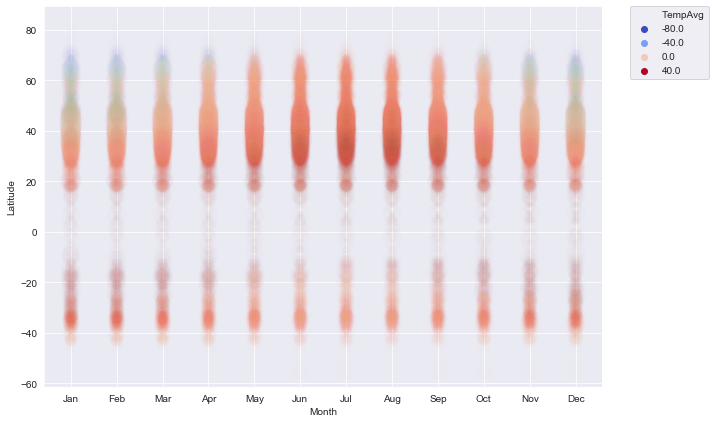

In [14]:
# Lets switch axis by plotting temp as color 
sns.scatterplot(x=dfTotal['Month'], 
                y=dfTotal['Latitude'], 
                hue=dfTotal['TempAvg'], 
                s=dfTotal['ElevationScale']*100, 
                alpha=0.01, 
                palette='coolwarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Oke this seems plausible: in june, july the nothern hemi is warmer, inverse for southern hemi

/Users/mckitchen/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


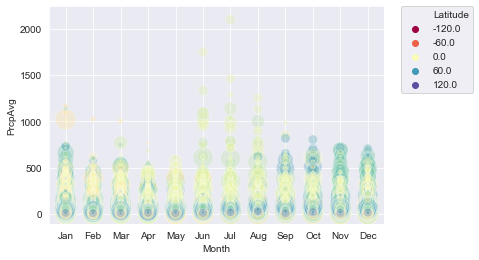

In [4]:
# How about the rain??
# Lets plot some data
sns.scatterplot(x=dfTotal['Month'], 
                y=dfTotal['PrcpAvg'], 
                hue=dfTotal['Latitude'], 
                s=dfTotal['Elevation']*0.1, 
                alpha=0.3, 
                palette='Spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

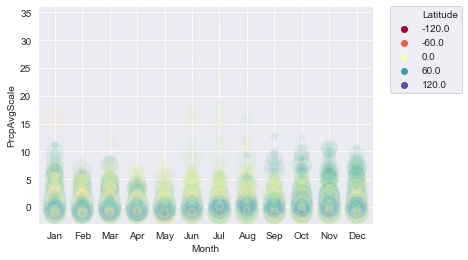

In [8]:
sns.scatterplot(x=dfTotal['Month'], 
                y=dfTotal['PrcpAvgScale'], 
                hue=dfTotal['Latitude'], 
                s=dfTotal['ElevationScale']*100, 
                alpha=0.1, 
                palette='Spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
# So oke, we know that the data seems plausible but the main point of this project was to look at spain
# So focus:
# Only select the data from spain to get a better idea how the weather is
dfSpain = dfTotal[dfTotal['Station'].str.match('SP')]
dfSpain = dfSpain[~dfSpain['Station'].str.match('SPE')]

dfSpain.to_pickle('dfSpain.pkl')

In [10]:
dfSpain = pd.read_pickle('dfSpain.pkl')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


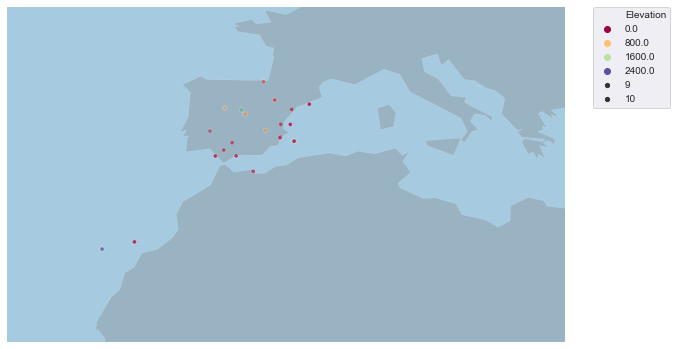

In [99]:
# Where in spain are we actually sampling the data from?
m=Basemap(llcrnrlon=-25, llcrnrlat=20, urcrnrlon=25, urcrnrlat=50)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# On top of that worldmap we now want to plot all the weather stations:
sns.scatterplot(x=dfSpain['Longitude'], 
                y=dfSpain['Latitude'], 
                hue=dfSpain['Elevation'], 
                alpha=0.1, 
                size=10,
                palette='Spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# um not a lot of data points but oke, data is what it is
plt.savefig('WeatherstationsSpainLocation.png', dpi= 150)

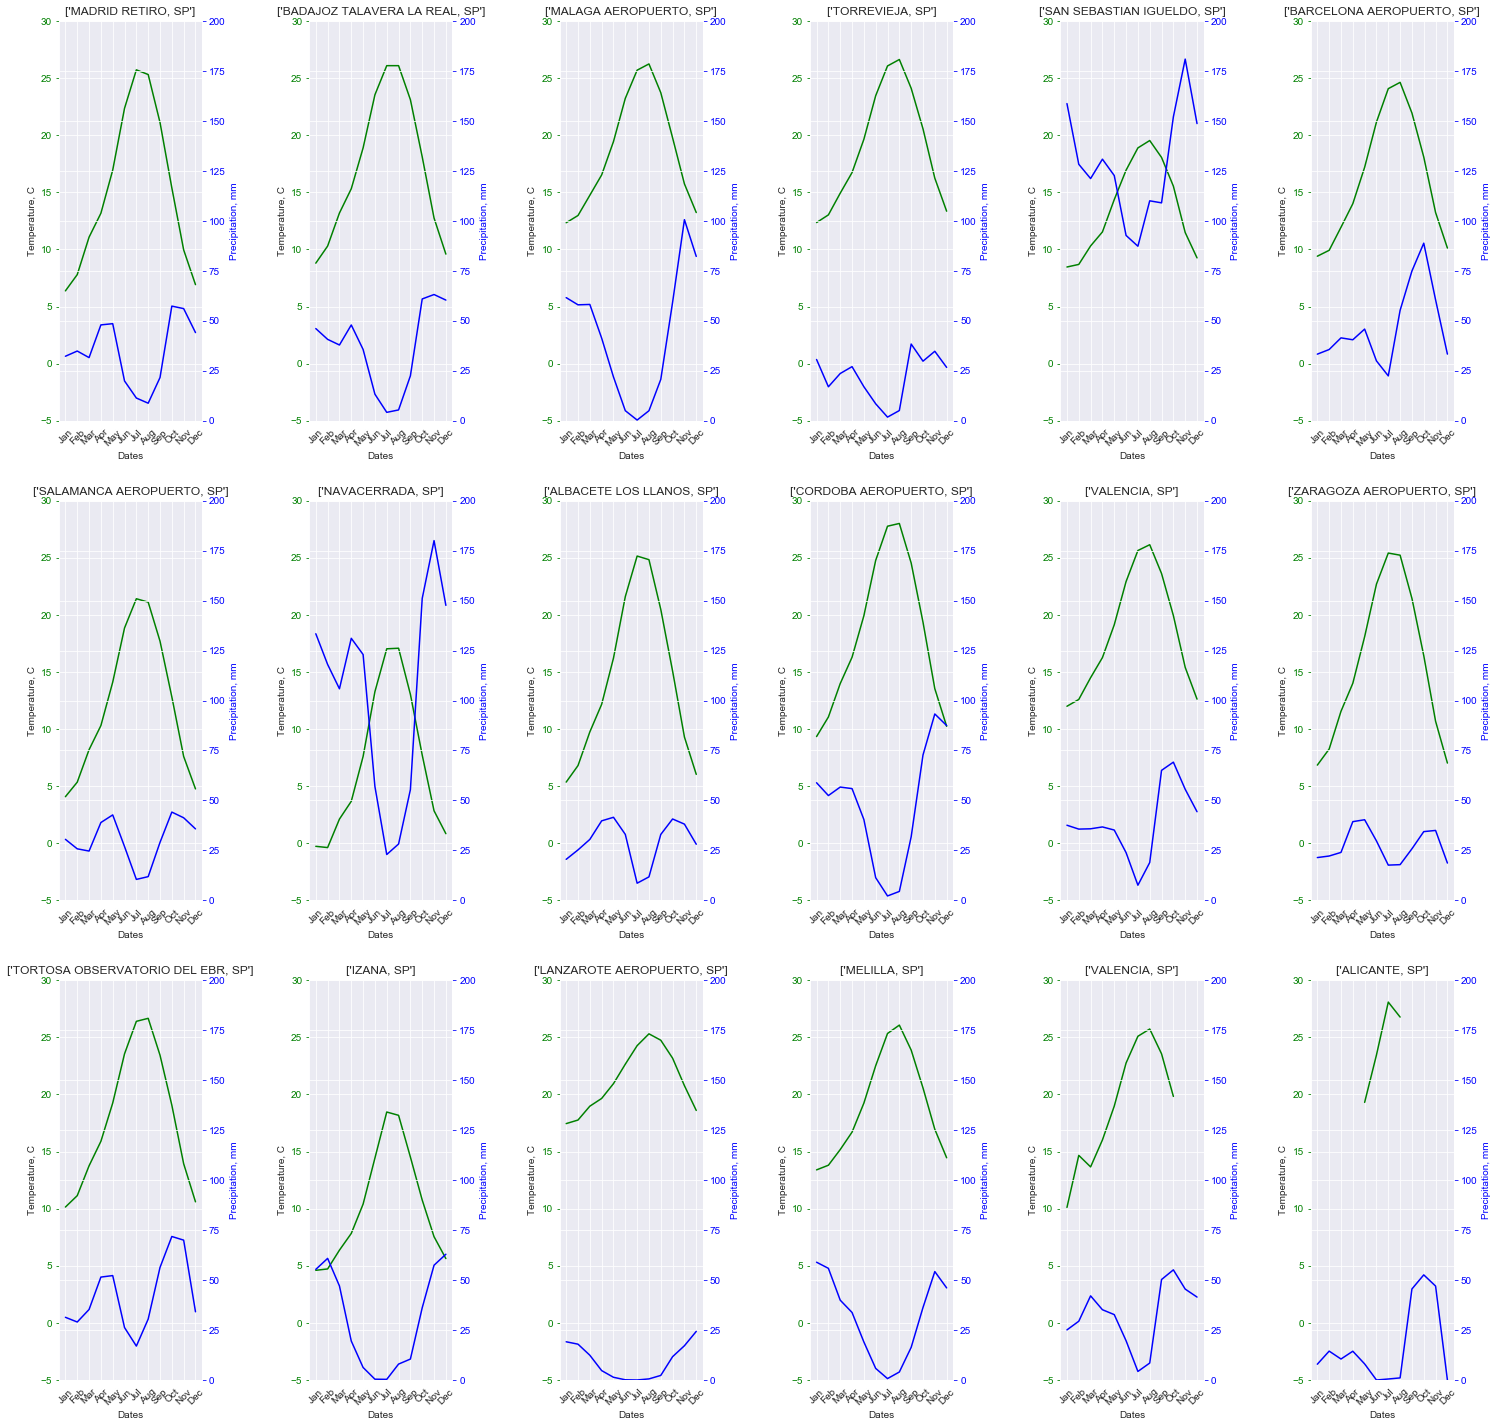

In [97]:
# So we know now where we are actually getting the data from. How about some classic 
# figures of temp and prcp?
grouped = dfSpain.groupby('Station')
rowlength = 6                    
fig, axs = plt.subplots(figsize=(25,25), 
                        nrows=3, ncols=rowlength,     
                        gridspec_kw=dict(wspace=0.75)) 

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):

    myDates = grouped['Month'].get_group(key)
    myValues = grouped['TempAvg'].get_group(key)

    ax.plot(myDates, myValues, 'g')
    ax.set_xlabel('Dates')
    ax.set_ylim(-5, 30)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    
    # Make the y-axis label, ticks and tick labels match the line color.
    ax.set_ylabel('Temperature, C')
    ax.tick_params('y', colors='g')

    ax1 = ax.twinx()
    myRain = grouped['PrcpAvg'].get_group(key)

    ax1.plot(myDates, myRain, color='b')
    ax1.set_ylabel('Precipitation, mm', color='b')
    ax1.set_ylim(0, 200)
    ax1.tick_params('y', colors='b')
    myStation = grouped['Name'].get_group(key).unique()
    ax.set_title(myStation)
plt.savefig('SpainWeatherStations.png', dpi=150)
plt.show()